# EDA

## 1. Project Overview

This notebook's objective is to perform **Exploratory Data Analysis (EDA)** on the dataset of Reddit posts and comments from political subreddits. The goal is to understand the structure of the data, analyze key features, and uncover patterns related to political alignment, sentiment, and text characteristics.

My EDA process will include:

1. **Political Distribution Analysis**: Explore comments' political alignment distribution and subreddit representation.
2. **Text Analysis**: Preprocess the text by removing stopwords, lemmatizing, and analyzing word frequency distributions to uncover common themes.
3. **Sentiment Analysis**: Perform sentiment analysis on the comments and explore how sentiment varies across subreddits, user flairs, and political alignments.
4. **Insights and Findings**: Summarize key findings, highlighting any interesting patterns, correlations, or unexpected results uncovered during the analysis.

## 2. Import Libraries and Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
import re

from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import bigrams, trigrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
df = pd.read_csv('./data/political_subreddit.csv', encoding='utf-8')

In [3]:
df.head()

,comment_id,post_id,subreddit,text,flair,political_alignment
0,gcba41x,jubtn1,AskALiberal,No. He has been quite the opposite. In my opin...,Progressive,0
1,gcb91pl,jubtn1,AskALiberal,>There’s also this sense among many Trump Supp...,Progressive,0
2,gcc9izo,jubtn1,AskALiberal,> He and his family have been making under the...,Social Democrat,0
3,iqqzidw,xtosah,AskALiberal,"People are paying attention to it, but there’s...",Social Democrat,0
4,iqr18vz,xtosah,AskALiberal,Because the people who control the conversatio...,Progressive,0


In [4]:
df.dtypes

comment_id             object
post_id                object
subreddit              object
text                   object
flair                  object
political_alignment     int64
dtype: object

In [5]:
df['political_alignment_label'] = df['political_alignment'].map({0: 'Democrat', 1: 'Republican'})

## 3. Comment Distribution Analysis

### 3.1 By Political Alignment (Demorat/Republican Alignment)

In [6]:
print(df['political_alignment_label'].value_counts())

political_alignment_label
Democrat      3928
Republican    3770
Name: count, dtype: int64


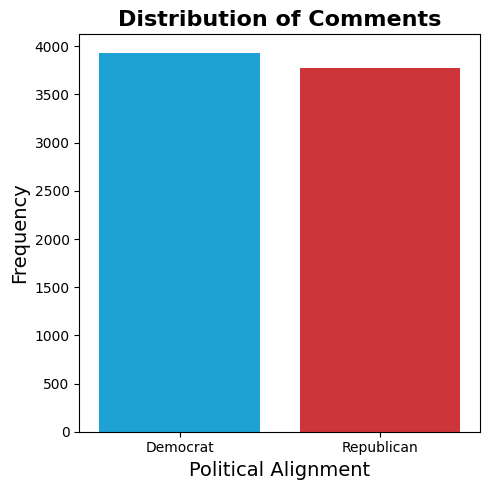

In [7]:
# Map political alignment (0, 1) to labels ('Democrat', 'Republican')
df['political_alignment_label'] = df['political_alignment'].map({0: 'Democrat', 1: 'Republican'})

# Define a custom color palette
custom_palette = {'Democrat': '#00AEF3',  # Blue
                  'Republican': '#E81B23'}  # Red

# Create the countplot with the custom colors
plt.figure(figsize=(5, 5))
sns.countplot(x='political_alignment_label', data=df, palette=custom_palette, hue='political_alignment_label', legend=False)

# Add titles and labels with customized fonts
plt.title('Distribution of Comments', fontsize=16, fontweight='bold')
plt.xlabel('Political Alignment', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

### 3.2 By Subreddit

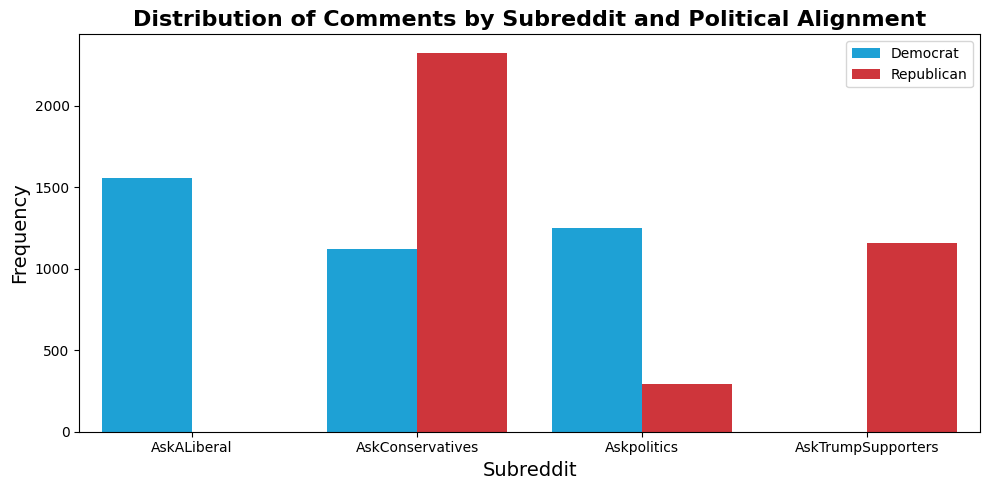

In [8]:
# Create the countplot for subreddits with hue based on political alignment
plt.figure(figsize=(10, 5))  # Adjust size for better visibility
sns.countplot(x='subreddit', data=df, hue='political_alignment_label', palette=custom_palette)

# Add titles and labels with customized fonts
plt.title('Distribution of Comments by Subreddit and Political Alignment', fontsize=16, fontweight='bold')
plt.xlabel('Subreddit', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.legend(title=None)
plt.tight_layout()
plt.show()

In [9]:
flair_counts = df['flair'].value_counts()
flair_counts

flair
Conservative             1168
Trump Supporter          1156
Liberal                  1054
Progressive              1011
Constitutionalist         438
Left-leaning              403
Democrat                  300
Leftist                   294
Social Democrat           210
Right-leaning             190
Paleoconservative         178
Democratic Socialist      177
Nationalist               170
Rightwing                 159
Social Democracy          136
Pragmatic Progressive     115
Leftwing                   95
Republican                 93
Conservatarian             91
Social Conservative        85
Neoliberal                 56
Far Left                   52
Neoconservative            42
Social Liberal             25
Name: count, dtype: int64

### 3.3 By User Flair

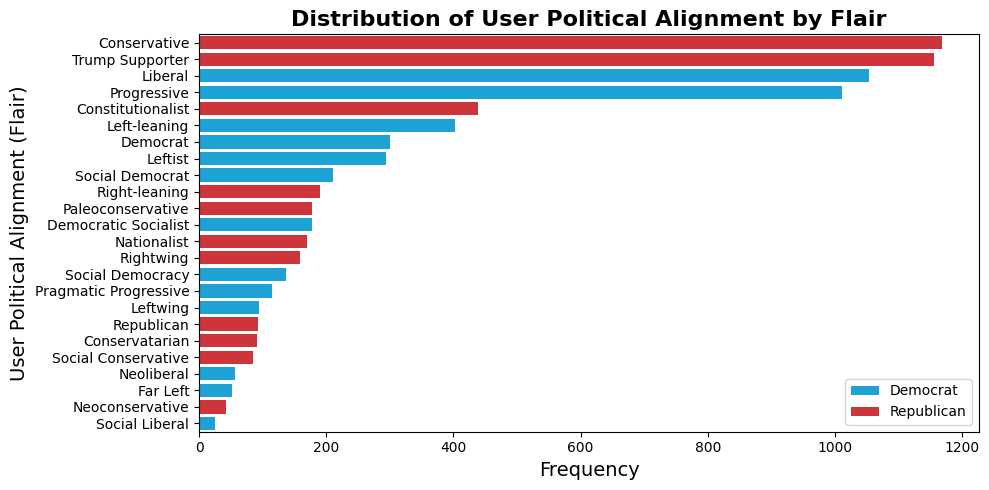

In [10]:
# Set the figure size
plt.figure(figsize=(10, 5))

# Create the countplot with the custom palette and hue for political alignment
sns.countplot(y='flair', data=df, hue='political_alignment_label', palette=custom_palette, 
              order=flair_counts.index) 

# Add title and labels
plt.title('Distribution of User Political Alignment by Flair', fontsize=16, fontweight='bold')
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('User Political Alignment (Flair)', fontsize=14)

# Adjust the legend to display correctly
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## 4. Text Analysis

### 4.1 Text Length Distribution

In [11]:
df['text_length'] = df['text'].apply(len)
df['text_length'].describe()

count    7698.000000
mean      762.613536
std       615.215371
min       250.000000
25%       422.000000
50%       571.000000
75%       860.000000
max      9777.000000
Name: text_length, dtype: float64

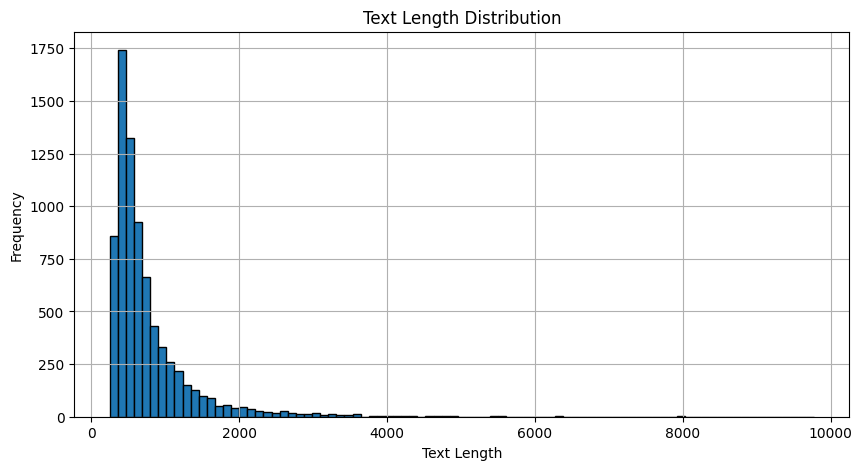

In [12]:
bins = int(7698 ** 0.5)
plt.figure(figsize=(10, 5))
df['text_length'].hist(bins=bins, edgecolor='black')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

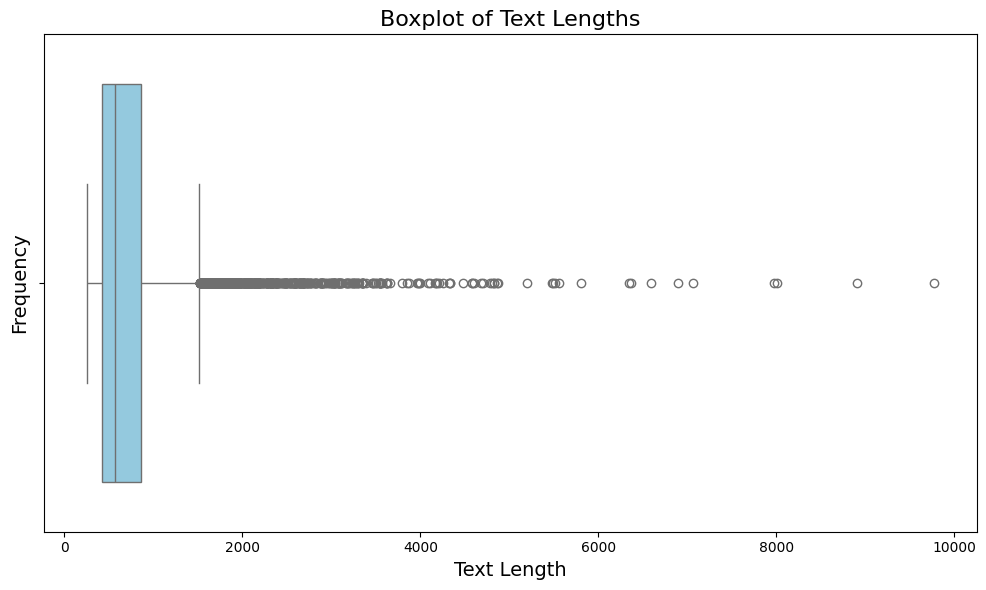

In [13]:
# Set figure size
plt.figure(figsize=(10, 6))

# Create the boxplot for text lengths
sns.boxplot(x=df['text_length'], color='skyblue')

# Add title and labels
plt.title('Boxplot of Text Lengths', fontsize=16)
plt.xlabel('Text Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

Longer posts, typically exceeding 2000 characters, tend to contain more detailed and opinionated content. These texts provide a richer source of information for my analysis, as they offer a deeper insight into the perspectives and sentiments of users. Therefore, focusing on these longer posts is essential for understanding more nuanced political viewpoints.

#### 4.1.1 By Political Alignment

In [14]:
# Define a custom color palette
custom_palette = {'Democrat': '#00AEF3',  # Blue
                  'Republican': '#E81B23'}

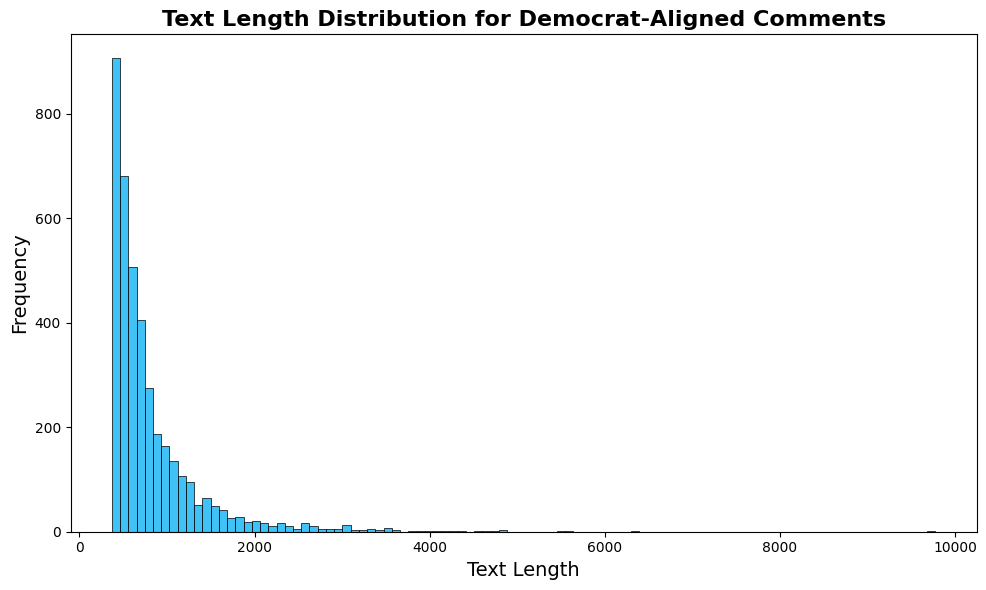

In [15]:
# Set the figure size for Democrat plot
plt.figure(figsize=(10, 6))

# Filter and plot Democrat aligned posts
df_democrat = df[df['political_alignment_label'] == 'Democrat']
sns.histplot(data=df_democrat, x='text_length', bins=100, color=custom_palette['Democrat'])

# Add title and labels for Democrat
plt.title('Text Length Distribution for Democrat-Aligned Comments', fontsize=16, fontweight='bold')
plt.xlabel('Text Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot for Democrat
plt.tight_layout()
plt.show()

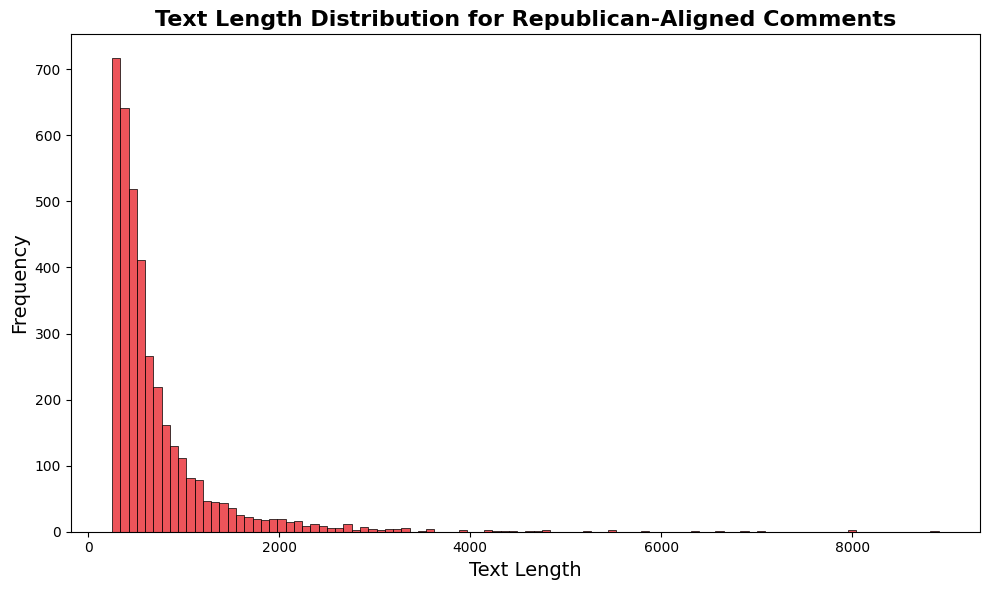

In [16]:
# Set the figure size for Republican plot
plt.figure(figsize=(10, 6))

# Filter and plot Republican aligned posts
df_republican = df[df['political_alignment_label'] == 'Republican']
sns.histplot(data=df_republican, x='text_length', bins=100, color=custom_palette['Republican'])

# Add title and labels for Republican
plt.title('Text Length Distribution for Republican-Aligned Comments', fontsize=16, fontweight='bold')
plt.xlabel('Text Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot for Republican
plt.tight_layout()
plt.show()

#### 4.1.2 By Subreddit

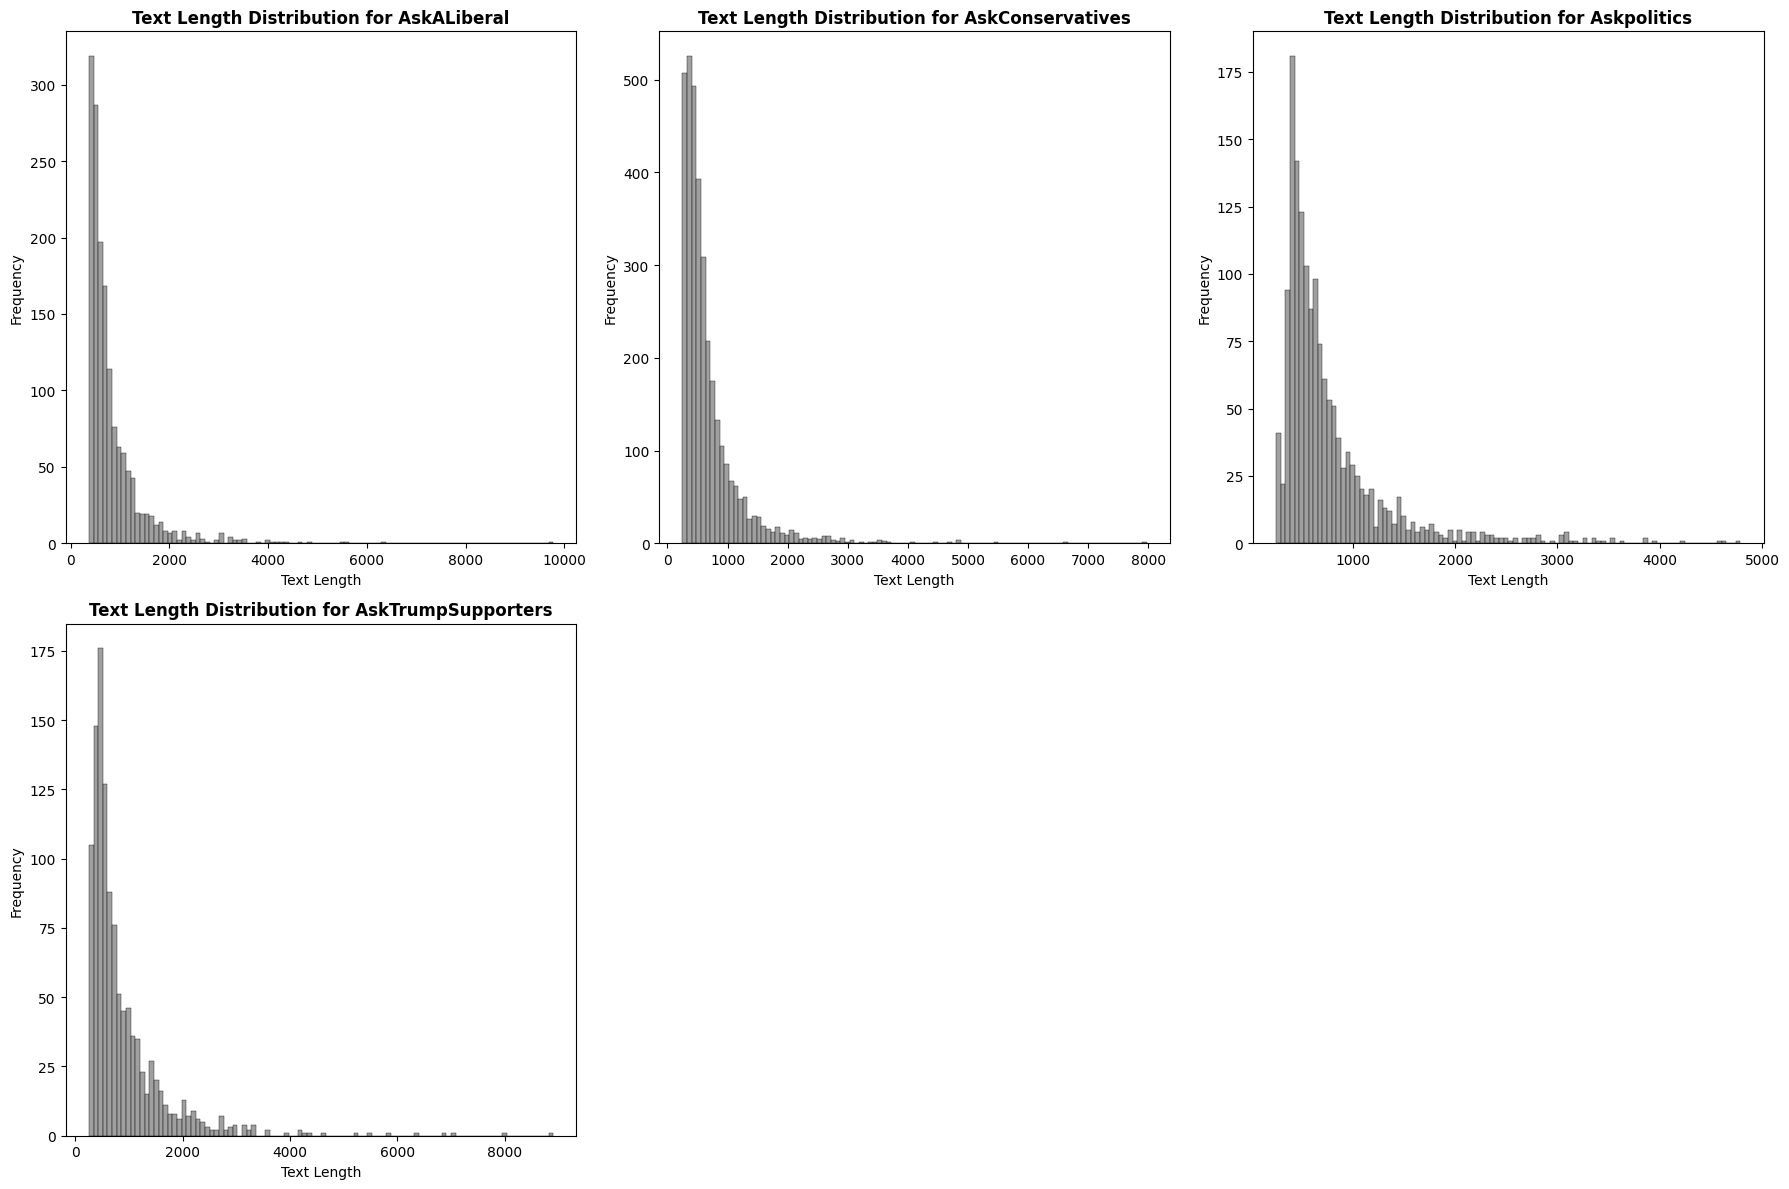

In [17]:
# Get the unique subreddits in your dataset
unique_subreddits = df['subreddit'].unique()

# Set the number of columns (3 per row)
n_cols = 3
n_rows = (len(unique_subreddits) // n_cols) + (len(unique_subreddits) % n_cols > 0)  # Calculate the number of rows needed

# Set the figure size for all subplots
plt.figure(figsize=(n_cols * 6, n_rows * 6))  # Adjust height based on number of rows

# Loop through each unique subreddit and create a subplot for each
for i, subreddit in enumerate(unique_subreddits, 1):
    # Filter the DataFrame for the current subreddit
    df_subreddit = df[df['subreddit'] == subreddit]
    
    # Get the political alignment for the current subreddit
    political_alignment = df_subreddit['political_alignment_label'].iloc[0]  # Assuming all entries in this subreddit have the same alignment
    
    # Choose the color based on political alignment
    color = '#808080'  # Default to gray if not found in custom_palette
    
    # Create a subplot for each subreddit
    plt.subplot(n_rows, n_cols, i)  # n_rows rows, n_cols columns, i-th subplot
    
    # Create the histogram for the current subreddit
    sns.histplot(data=df_subreddit, x='text_length', bins=100, color=color)
    
    # Add title and labels for the current subreddit
    plt.title(f'Text Length Distribution for {subreddit}', fontsize=12, fontweight='bold')
    plt.xlabel('Text Length', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)

# Adjust layout to ensure the plots don't overlap
plt.tight_layout()
plt.show()

#### 4.1.3 By User Flair

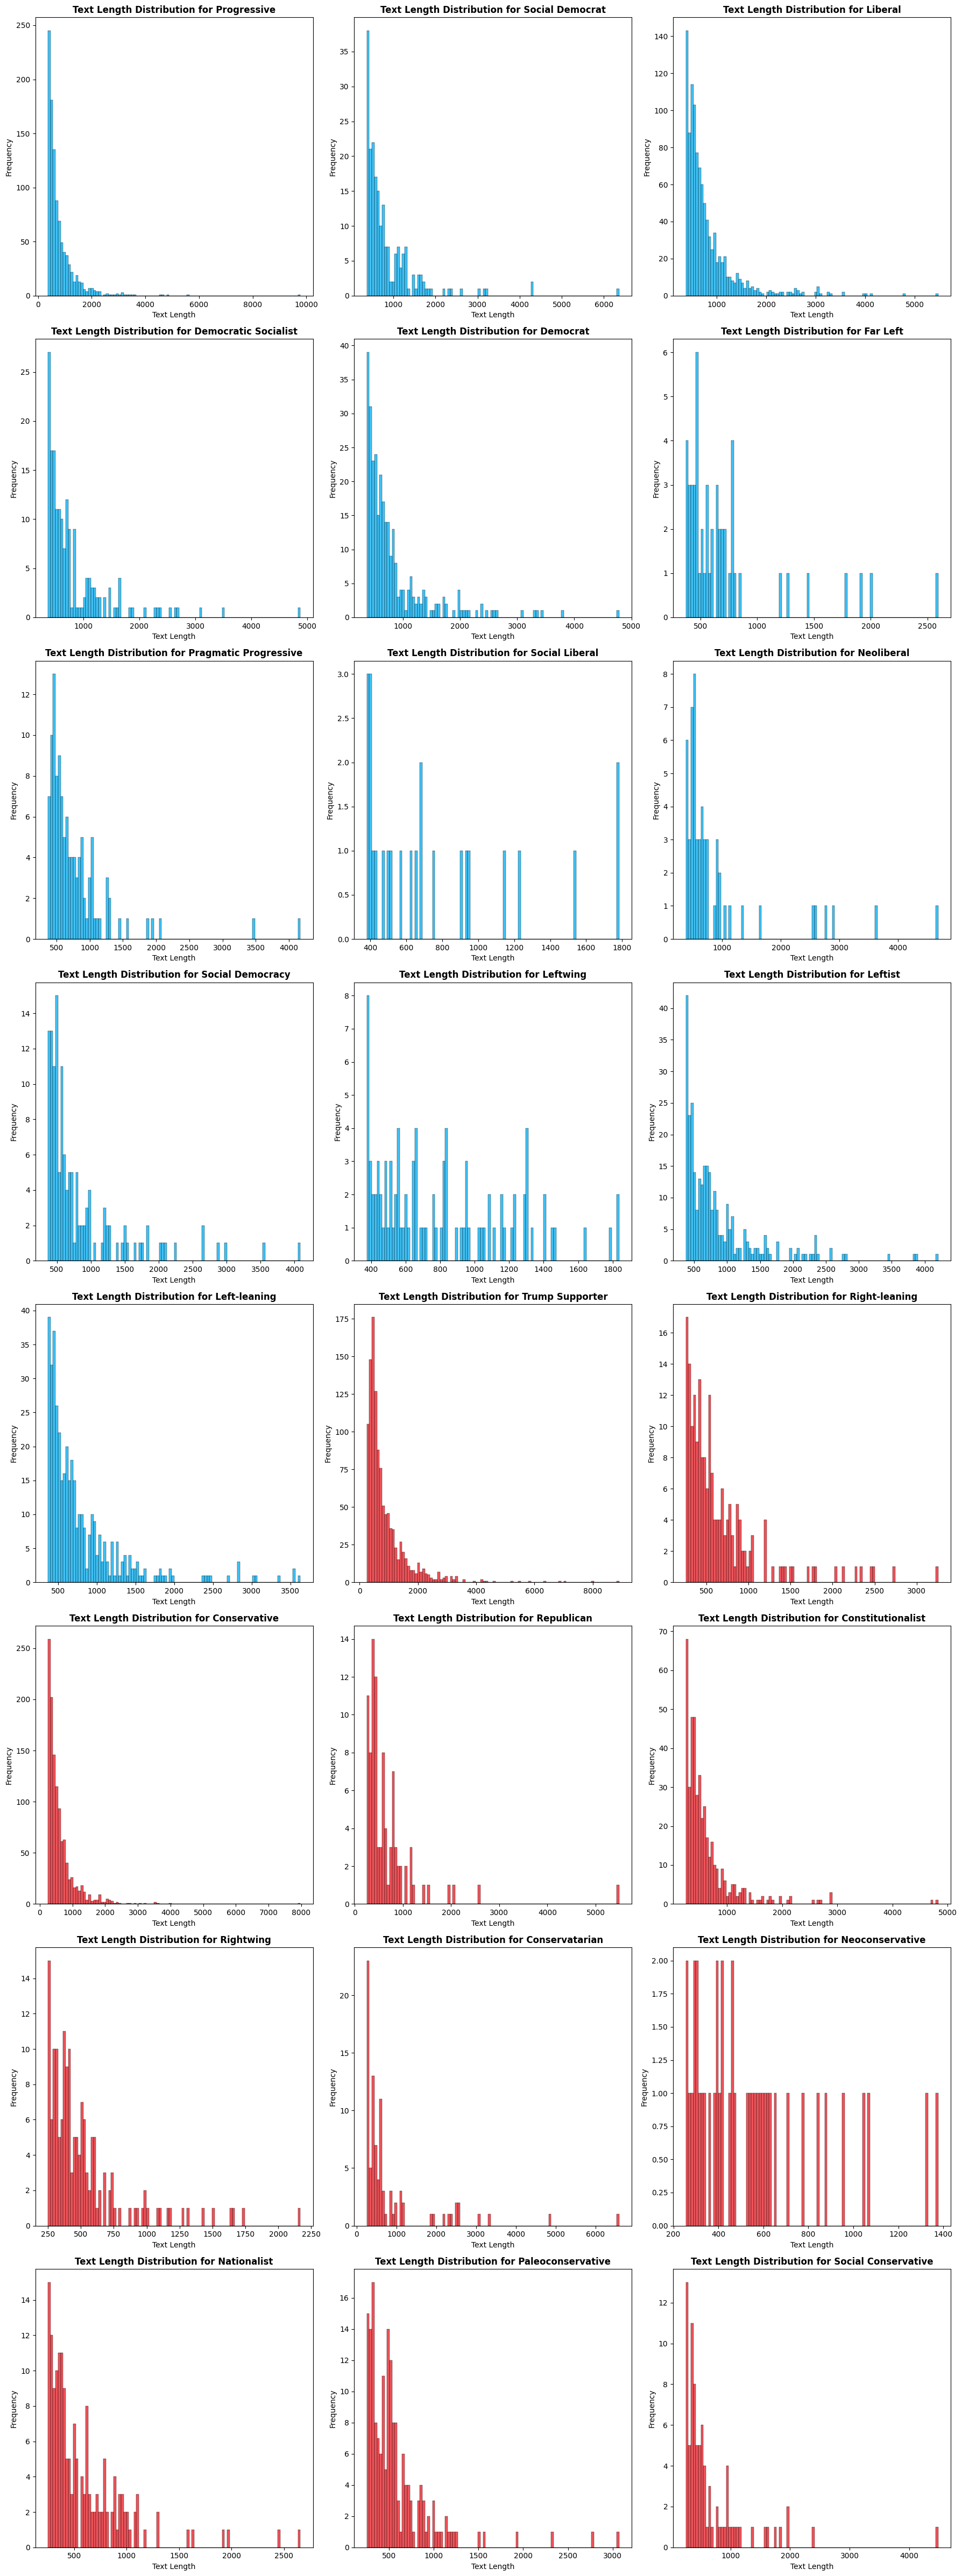

In [18]:
# Get the unique flairs in your dataset
unique_flairs = df['flair'].unique()

# Set the number of columns (3 per row)
n_cols = 3
n_rows = (len(unique_flairs) // n_cols) + (len(unique_flairs) % n_cols > 0)  # Calculate the number of rows needed

# Set the figure size for all subplots
plt.figure(figsize=(n_cols * 6, n_rows * 6))  # Adjust height based on number of rows

# Loop through each unique flair and create a subplot for each
for i, flair in enumerate(unique_flairs, 1):
    # Filter the DataFrame for the current flair
    df_flair = df[df['flair'] == flair]
    
    # Get the political alignment for the current flair
    political_alignment = df_flair['political_alignment_label'].iloc[0]  # Assuming all entries in this flair have the same alignment
    
    # Choose the color based on political alignment
    color = custom_palette.get(political_alignment, '#808080')  # Default to gray if not found in custom_palette
    
    # Create a subplot for each flair
    plt.subplot(n_rows, n_cols, i)  # n_rows rows, n_cols columns, i-th subplot
    
    # Create the histogram for the current flair
    sns.histplot(data=df_flair, x='text_length', bins=100, color=color)
    
    # Add title and labels for the current flair
    plt.title(f'Text Length Distribution for {flair}', fontsize=12, fontweight='bold')
    plt.xlabel('Text Length', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)

# Adjust layout to ensure the plots don't overlap
plt.tight_layout()
plt.show()

### 4.2 NLP

In [19]:
nlp_text = df.copy()

#### 4.2.1 Text Normalization

In [20]:
# Convert to lowercase
nlp_text['text'] = nlp_text['text'].str.lower()

In [21]:
# Remove URLs, hashtags, numbers and URLs
nlp_text['text'] = nlp_text['text'].str.replace(r'http\S+|www\S+', '', regex=True)  # Remove URLs
nlp_text['text'] = nlp_text['text'].str.replace(r'@\w+', '', regex=True)  # Remove mentions (@user)
nlp_text['text'] = nlp_text['text'].str.replace(r'[#\d]', '', regex=True)  # Remove hashtags and numbers

In [22]:
# Remove non-alphabetical characters
nlp_text['text'] = nlp_text['text'].str.replace(r'[^a-z\s]', '', regex=True)

In [23]:
# Handle contractions
nlp_text['text'] = nlp_text['text'].apply(lambda x: contractions.fix(x))

#### 4.2.2 Tokenization

In [24]:
# Tokenize the text into individual words
nlp_text['tokens'] = nlp_text['text'].apply(word_tokenize)

#### 4.2.3 Stopword Removal

In [25]:
# Define stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords
nlp_text['tokens'] = nlp_text['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

#### 4.2.4 Lemmatization

In [26]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize each token
nlp_text['tokens'] = nlp_text['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

#### 4.2.5 Bigrams and Trigrams

In [27]:
# Function to generate bigrams and trigrams
def generate_ngrams(tokens, n=2):
    if n == 2:
        return list(bigrams(tokens))  # Generate bigrams
    elif n == 3:
        return list(trigrams(tokens))  # Generate trigrams

In [28]:
# Generate bigrams and trigrams from the 'tokens' column (preprocessed text)
nlp_text['bigrams'] = nlp_text['tokens'].apply(lambda x: generate_ngrams(x, n=2))  # Bigrams
nlp_text['trigrams'] = nlp_text['tokens'].apply(lambda x: generate_ngrams(x, n=3))  # Trigrams

### 4.3 Most Common Words

#### 4.3.1 Unigrams

##### General Overview

In [29]:
# Flatten the 'tokens' column into a single list of words
all_tokens = [word for tokens_list in nlp_text['tokens'] for word in tokens_list]

# Count the frequency of each word using Counter
word_counts = Counter(all_tokens)

# Convert the word_counts to a DataFrame for easy viewing
word_count_df = pd.DataFrame(word_counts.items(), columns=['word', 'count'])

# Sort the DataFrame by the count in descending order
word_count_df = word_count_df.sort_values(by='count', ascending=False)

# Show the top 15 most frequent words
print(word_count_df.head(15))

       word  count
66   people   5902
266   would   4527
74    trump   4282
4      like   3772
361   think   3313
69      one   2544
15    right   2354
274     get   2350
108       u   2334
232   thing   2327
166    want   2179
47     even   2052
197    make   1839
95     time   1761
70     also   1756


<Figure size 1000x600 with 0 Axes>

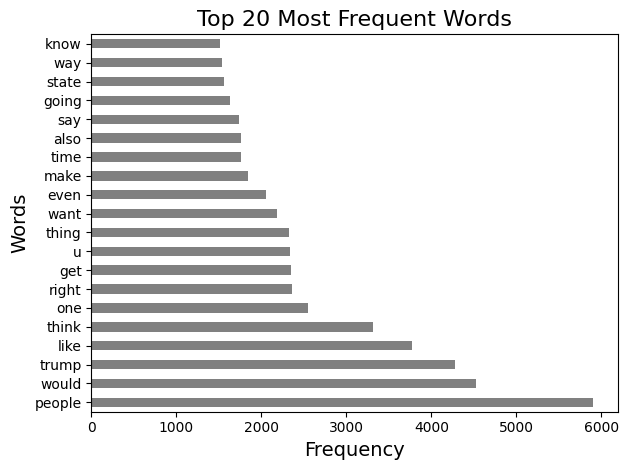

In [30]:
# Get the top 20 most frequent words
top_20_words = word_count_df.head(20)

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
top_20_words.plot(kind='barh', x='word', y='count', color='gray', legend=False)

# Add title and labels
plt.title('Top 20 Most Frequent Words', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Words', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

##### By Political Alignment

In [31]:
# Initialize a dictionary to store word counts for each political alignment
alignment_word_counts = {}

# Loop through each political alignment (Democrat, Republican)
for alignment in ['Democrat', 'Republican']:
    # Filter the DataFrame based on the political alignment
    df_alignment = nlp_text[nlp_text['political_alignment_label'] == alignment]
    
    # Flatten the list of tokens for the specific political alignment
    all_tokens = [word for tokens_list in df_alignment['tokens'] for word in tokens_list]
    
    # Count the frequency of each word
    word_counts = Counter(all_tokens)
    
    # Store the most common words in the dictionary
    alignment_word_counts[alignment] = word_counts.most_common(20)

In [32]:
# Create DataFrames for the top 20 words for each political alignment
top_20_democrat = pd.DataFrame(alignment_word_counts['Democrat'], columns=['word', 'count'])
top_20_republican = pd.DataFrame(alignment_word_counts['Republican'], columns=['word', 'count'])

<Figure size 1000x600 with 0 Axes>

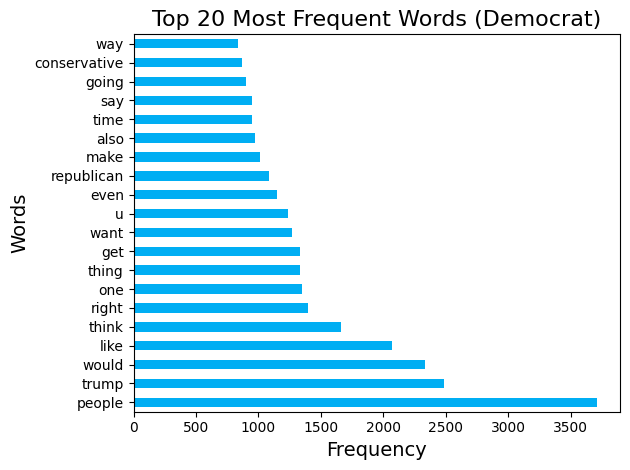

In [33]:
# Create a horizontal bar plot for Democrat
plt.figure(figsize=(10, 6))
top_20_democrat.plot(kind='barh', x='word', y='count', color=custom_palette['Democrat'], legend=False)

# Add titles and labels for Democrat plot
plt.title('Top 20 Most Frequent Words (Democrat)', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Words', fontsize=14)

# Show the plot for Democrat
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

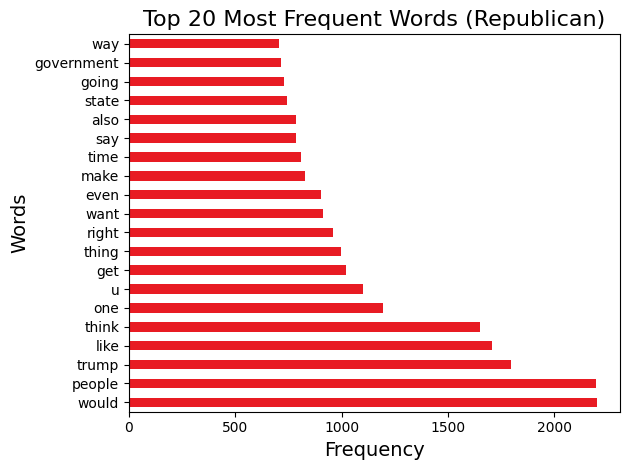

In [34]:
# Create a horizontal bar plot for Republican
plt.figure(figsize=(10, 6))
top_20_republican.plot(kind='barh', x='word', y='count', color=custom_palette['Republican'], legend=False)

# Add titles and labels for Republican plot
plt.title('Top 20 Most Frequent Words (Republican)', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Words', fontsize=14)

# Show the plot for Republican
plt.tight_layout()
plt.show()

#### 4.3.2 Bigrams

##### General Overview

In [35]:
# Flatten the 'bigrams' column into a single list of bigrams
all_bigrams = [bigram for bigram_list in nlp_text['bigrams'] for bigram in bigram_list]

# Count the frequency of each bigram using Counter
bigram_counts = Counter(all_bigrams)

# Convert the bigram_counts to a DataFrame for easy viewing
bigram_count_df = pd.DataFrame(bigram_counts.items(), columns=['bigram', 'count'])

# Sort the DataFrame by the count in descending order
bigram_count_df = bigram_count_df.sort_values(by='count', ascending=False)

# Show the top 15 most frequent bigrams
print(bigram_count_df.head(15))

                     bigram  count
344                (let, u)    254
197         (united, state)    229
5152           (feel, like)    187
1496         (many, people)    162
4581          (right, wing)    154
2513         (even, though)    151
1261            (year, ago)    151
615          (people, like)    149
4107  (federal, government)    145
75       (trump, supporter)    141
1372          (seems, like)    139
1961           (look, like)    135
2836       (social, medium)    131
1922    (republican, party)    131
385        (supreme, court)    130


<Figure size 1000x600 with 0 Axes>

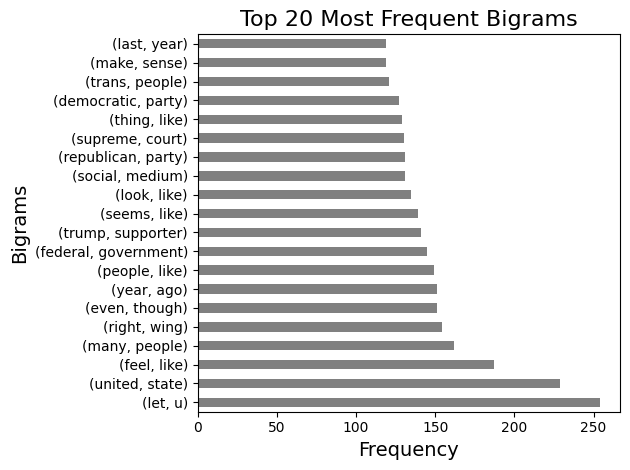

In [36]:
# Get the top 20 most frequent bigrams
top_20_bigrams = bigram_count_df.head(20)

# Create a horizontal bar plot for bigrams
plt.figure(figsize=(10, 6))
top_20_bigrams.plot(kind='barh', x='bigram', y='count', color='gray', legend=False)

# Add title and labels
plt.title('Top 20 Most Frequent Bigrams', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Bigrams', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

##### By Political Alignment

In [37]:
# Initialize a dictionary to store bigram counts for each political alignment
bigram_count = {'Democrat': [], 'Republican': []}

# Loop through each political alignment (Democrat, Republican)
for alignment in ['Democrat', 'Republican']:
    # Filter the DataFrame based on the political alignment
    df_alignment = nlp_text[nlp_text['political_alignment_label'] == alignment]
    
    # Flatten the list of bigrams for the specific political alignment
    all_bigrams = [bigram for bigrams_list in df_alignment['bigrams'] for bigram in bigrams_list]
    
    # Count the frequency of each bigram
    bigram_counts = Counter(all_bigrams)
    
    # Store the most common bigrams in the dictionary
    bigram_count[alignment] = bigram_counts.most_common(20)

In [38]:
# Convert the bigram count for each alignment into a DataFrame
democrat_bigrams_df = pd.DataFrame(bigram_count['Democrat'], columns=['bigram', 'count'])
republican_bigrams_df = pd.DataFrame(bigram_count['Republican'], columns=['bigram', 'count'])

In [39]:
print(democrat_bigrams_df.head(20))

                 bigram  count
0              (let, u)    150
1          (feel, like)    120
2       (united, state)    118
3         (right, wing)    112
4       (trans, people)    104
5        (many, people)    102
6           (year, ago)    101
7   (democratic, party)     97
8        (people, like)     93
9   (republican, party)     92
10     (supreme, court)     90
11      (donald, trump)     79
12        (lot, people)     78
13        (seems, like)     77
14   (trump, supporter)     74
15     (social, medium)     74
16         (look, like)     73
17       (even, though)     73
18     (working, class)     72
19        (thing, like)     69


<Figure size 1000x600 with 0 Axes>

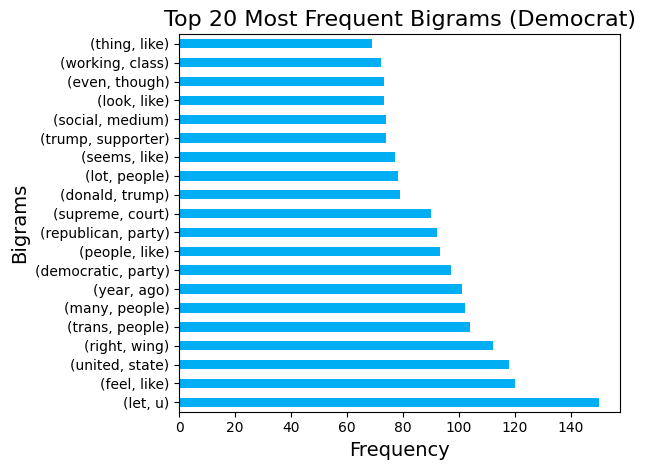

In [40]:
# Plot for Democrat
plt.figure(figsize=(10, 6))
democrat_bigrams_df.plot(kind='barh', x='bigram', y='count', color=custom_palette['Democrat'], legend=False)

# Add titles and labels for Democrat plot
plt.title('Top 20 Most Frequent Bigrams (Democrat)', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Bigrams', fontsize=14)

# Show the plot for Democrat
plt.tight_layout()
plt.show()

In [41]:
print(republican_bigrams_df.head(20))

                    bigram  count
0          (united, state)    111
1                 (let, u)    104
2    (federal, government)     92
3           (even, though)     78
4       (trump, supporter)     67
5             (feel, like)     67
6             (one, thing)     65
7             (look, like)     62
8            (seems, like)     62
9           (many, people)     60
10           (thing, like)     60
11              (tax, cut)     60
12       (something, like)     57
13        (social, medium)     57
14            (would, say)     56
15          (people, like)     56
16            (last, year)     54
17  (illegal, immigration)     54
18           (make, sense)     50
19          (think, trump)     50


<Figure size 1000x600 with 0 Axes>

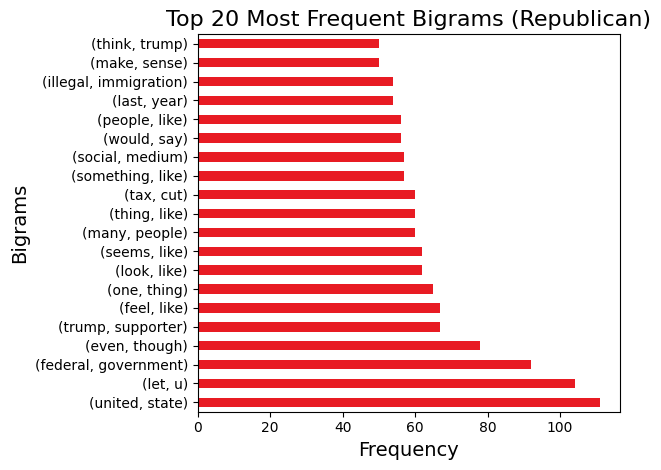

In [42]:
# Plot for Republican
plt.figure(figsize=(10, 6))
republican_bigrams_df.plot(kind='barh', x='bigram', y='count', color=custom_palette['Republican'], legend=False)

# Add titles and labels for Republican plot
plt.title('Top 20 Most Frequent Bigrams (Republican)', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Bigrams', fontsize=14)

# Show the plot for Republican
plt.tight_layout()
plt.show()

#### 4.3.3 Trigrams

##### General Overview

In [43]:
# Flatten the 'bigrams' column into a single list of bigrams
all_trigrams = [trigram for trigram_list in nlp_text['trigrams'] for trigram in trigram_list]

# Count the frequency of each bigram using Counter
trigram_counts = Counter(all_trigrams)

# Convert the bigram_counts to a DataFrame for easy viewing
trigram_count_df = pd.DataFrame(trigram_counts.items(), columns=['trigram', 'count'])

# Sort the DataFrame by the count in descending order
trigram_count_df = trigram_count_df.sort_values(by='count', ascending=False)

# Show the top 15 most frequent bigrams
print(trigram_count_df.head(15))

                              trigram  count
14296                   (let, u, say)     34
8535            (right, wing, medium)     30
181488               (red, flag, law)     20
76162             (civil, right, act)     19
17328                  (roe, v, wade)     18
12990              (donald, j, trump)     18
24513      (president, united, state)     16
13882           (social, safety, net)     14
36060             (lesser, two, evil)     13
20738              (make, look, like)     13
5059           (people, voted, trump)     13
7102    (sexual, orientation, gender)     13
44498         (every, single, person)     12
2558             (two, party, system)     12
46982        (working, class, people)     12


<Figure size 1000x600 with 0 Axes>

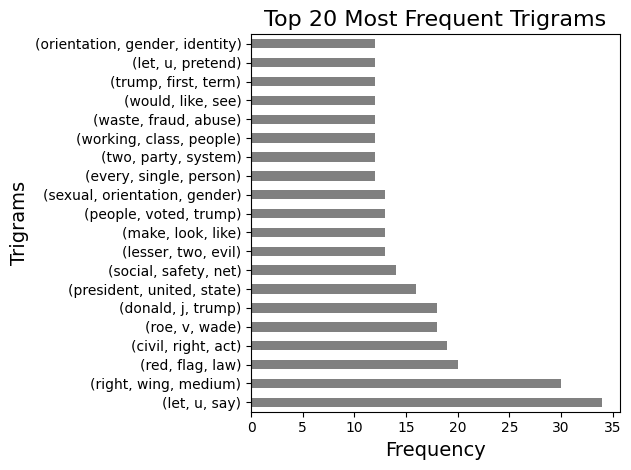

In [44]:
# Get the top 20 most frequent bigrams
top_20_trigrams = trigram_count_df.head(20)

# Create a horizontal bar plot for bigrams
plt.figure(figsize=(10, 6))
top_20_trigrams.plot(kind='barh', x='trigram', y='count', color='gray', legend=False)

# Add title and labels
plt.title('Top 20 Most Frequent Trigrams', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Trigrams', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

##### By Political Alignment

In [45]:
# Initialize a dictionary to store trigram counts for each political alignment
trigram_count = {'Democrat': [], 'Republican': []}

# Loop through each political alignment (Democrat, Republican)
for alignment in ['Democrat', 'Republican']:
    # Filter the DataFrame based on the political alignment
    df_alignment = nlp_text[nlp_text['political_alignment_label'] == alignment]
    
    # Flatten the list of trigrams for the specific political alignment
    all_trigrams = [trigram for trigrams_list in df_alignment['trigrams'] for trigram in trigrams_list]
    
    # Count the frequency of each trigram
    trigram_counts = Counter(all_trigrams)
    
    # Store the most common trigrams in the dictionary
    trigram_count[alignment] = trigram_counts.most_common(20)

In [46]:
# Convert the trigram count for each alignment into a DataFrame
democrat_trigrams_df = pd.DataFrame(trigram_count['Democrat'], columns=['trigram', 'count'])
republican_trigrams_df = pd.DataFrame(trigram_count['Republican'], columns=['trigram', 'count'])

In [47]:
print(democrat_trigrams_df.head(20))

                            trigram  count
0             (right, wing, medium)     28
1                     (let, u, say)     19
2                    (roe, v, wade)     15
3     (sexual, orientation, gender)     13
4   (orientation, gender, identity)     12
5            (people, voted, trump)     11
6       (critical, thinking, skill)     11
7          (working, class, people)     11
8               (civil, right, act)     11
9              (two, party, system)     10
10         (united, state, america)     10
11                (let, u, pretend)      9
12       (president, united, state)      9
13              (lesser, two, evil)      9
14       (social, medium, platform)      9
15                 (wong, kim, ark)      9
16              (first, past, post)      8
17         (vast, majority, people)      8
18        (supreme, court, justice)      8
19            (black, life, matter)      8


<Figure size 1000x600 with 0 Axes>

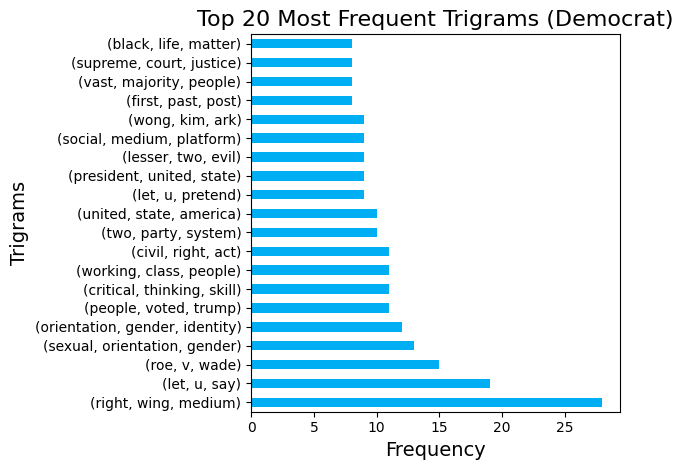

In [48]:
# Plot for Democrat
plt.figure(figsize=(10, 6))
democrat_trigrams_df.plot(kind='barh', x='trigram', y='count', color=custom_palette['Democrat'], legend=False)

# Add titles and labels for Democrat plot
plt.title('Top 20 Most Frequent Trigrams (Democrat)', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Trigrams', fontsize=14)

# Show the plot for Democrat
plt.tight_layout()
plt.show()

In [49]:
print(republican_trigrams_df.head(20))

                             trigram  count
0                   (red, flag, law)     17
1                      (let, u, say)     15
2                 (donald, j, trump)     12
3          (hitler, supporter, nazi)     11
4                 (would, like, see)      9
5             (supply, side, policy)      9
6            (supporter, nazi, like)      9
7                 (nazi, like, call)      9
8                    (id, like, see)      8
9                (civil, right, act)      8
10             (social, safety, net)      8
11        (president, united, state)      7
12  (subject, jurisdiction, thereof)      7
13          (support, gay, marriage)      7
14        (general, welfare, clause)      7
15             (waste, fraud, abuse)      7
16            (law, armed, conflict)      7
17           (every, single, person)      7
18            (like, everyone, else)      6
19          (something, along, line)      6


<Figure size 1000x600 with 0 Axes>

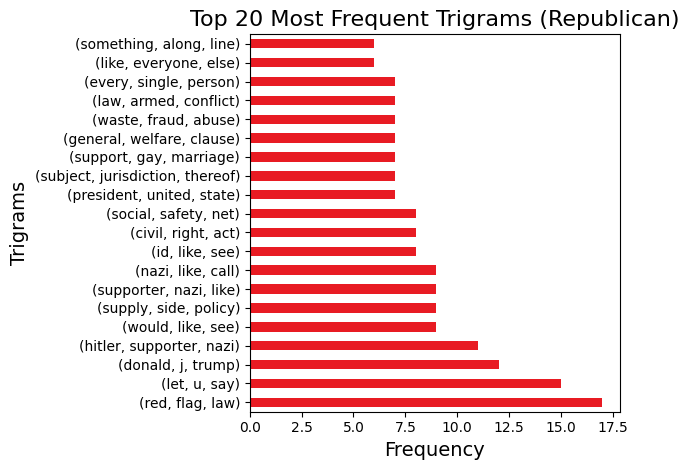

In [50]:
# Plot for Republican
plt.figure(figsize=(10, 6))
republican_trigrams_df.plot(kind='barh', x='trigram', y='count', color=custom_palette['Republican'], legend=False)

# Add titles and labels for Republican plot
plt.title('Top 20 Most Frequent Trigrams (Republican)', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Trigrams', fontsize=14)

# Show the plot for Republican
plt.tight_layout()
plt.show()

## 5. Sentiment Analysis

### 5.1 NLP for Sentiment Analysis

In [51]:
def normalize_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions (@user)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

In [52]:
# Apply the normalization function to the 'text' column
df['normalized_text'] = df['text'].apply(normalize_text)

### 5.2 VADER Sentiment Analysis

In [53]:
# Initialize VADER
sia = SentimentIntensityAnalyzer()

In [54]:
# Sentiment analysis function
def analyze_text_vader(text, method="average"):
    """Splits text into sentences, analyzes sentiment for each, and computes overall sentiment."""
    if not isinstance(text, str) or text.strip() == "":  # Handle NaN or empty text
        return 0  # Neutral sentiment if text is missing or empty

    sentences = sent_tokenize(text)  # Split text into sentences
    sentiment_scores = [sia.polarity_scores(sentence)['compound'] for sentence in sentences]

    if not sentiment_scores:  # Ensure it's not an empty list
        return 0  # Neutral sentiment

    if method == "average":
        return np.mean(sentiment_scores)  # Get the average sentiment
    elif method == "median":
        return np.median(sentiment_scores)  # Get the median sentiment
    else:
        raise ValueError("Method must be 'average' or 'median'.")

In [55]:
# Apply sentiment analysis to dataframe
df['vader_sentiment_avg'] = df['normalized_text'].apply(lambda x: analyze_text_vader(x, method="average"))
df['vader_sentiment_median'] = df['normalized_text'].apply(lambda x: analyze_text_vader(x, method="median"))

In [56]:
# Assign vader sentiment values for each subset based on the original dataframe
df_democrat.loc[:, 'vader_sentiment_avg'] = df.loc[df_democrat.index, 'vader_sentiment_avg']
df_republican.loc[:, 'vader_sentiment_avg'] = df.loc[df_republican.index, 'vader_sentiment_avg']

C:\Users\eomar\AppData\Local\Temp\ipykernel_89744\1814213472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_democrat.loc[:, 'vader_sentiment_avg'] = df.loc[df_democrat.index, 'vader_sentiment_avg']
C:\Users\eomar\AppData\Local\Temp\ipykernel_89744\1814213472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_republican.loc[:, 'vader_sentiment_avg'] = df.loc[df_republican.index, 'vader_sentiment_avg']


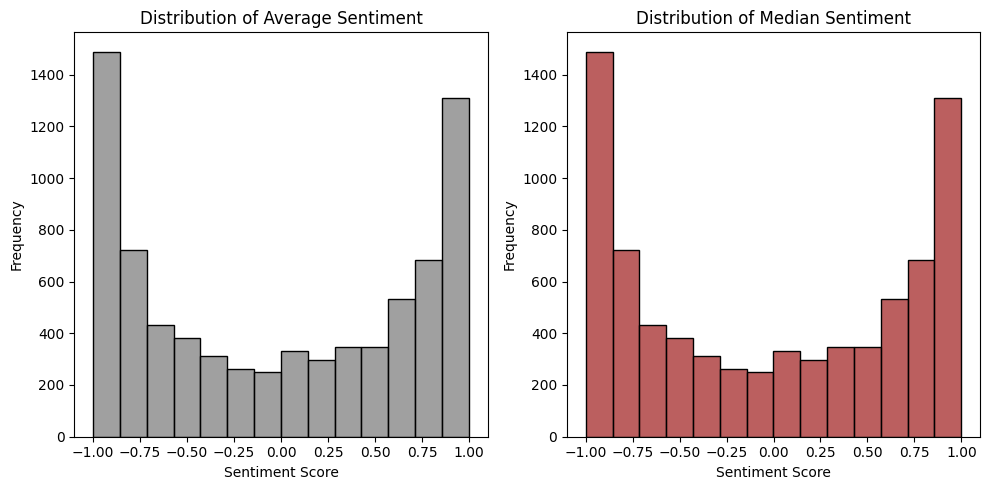

In [57]:
# Set figure size
plt.figure(figsize=(10, 5))

# Plot for Average Sentiment
plt.subplot(1, 2, 1)
sns.histplot(df['vader_sentiment_avg'], color="gray")
plt.title("Distribution of Average Sentiment")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")

# Plot for Median Sentiment
plt.subplot(1, 2, 2)
sns.histplot(df['vader_sentiment_median'], color="brown")
plt.title("Distribution of Median Sentiment")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")

# Show the plots
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

### 5.3 Sentiment Analysis by Political Alignment

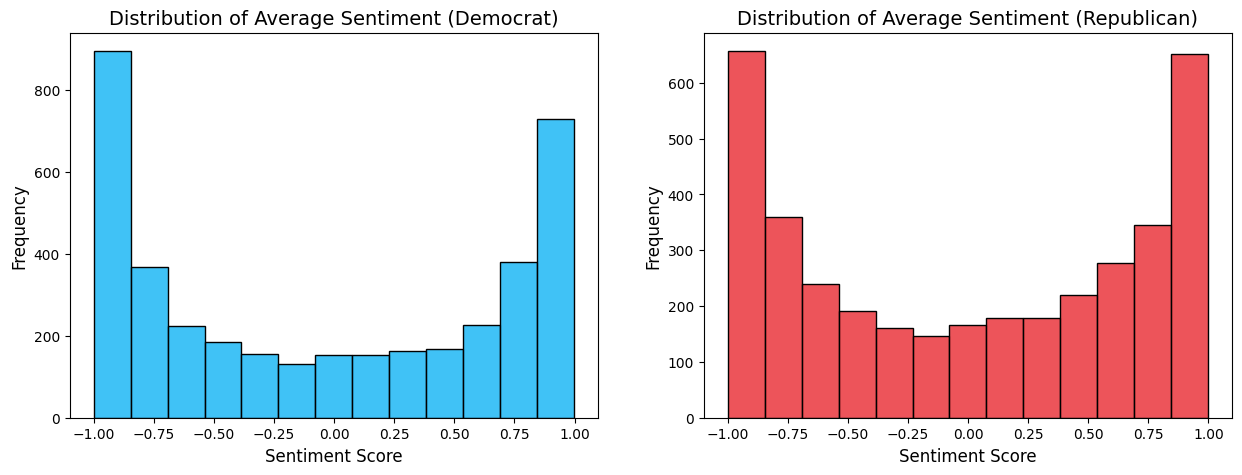

In [58]:
# Set figure size
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_democrat['vader_sentiment_avg'], color=custom_palette['Democrat'])
plt.title("Distribution of Average Sentiment (Democrat)", fontsize=14)
plt.xlabel("Sentiment Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.subplot(1, 2, 2)
sns.histplot(df_republican['vader_sentiment_avg'], color=custom_palette['Republican'])
plt.title("Distribution of Average Sentiment (Republican)", fontsize=14)
plt.xlabel("Sentiment Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.show()

### 5.4 Sentiment Analysis on Common Words

#### 5.4.1 Posts containing "Trump"

In [59]:
df_trump = df[df['normalized_text'].str.contains('trump', case=False, na=False)]

In [60]:
# Filter for Democrat-aligned posts containing 'Trump'
df_trump_democrat = df_trump[df_trump['political_alignment_label'] == 'Democrat']

In [61]:
# Filter for Republican-aligned posts containing 'Trump'
df_trump_republican = df_trump[df_trump['political_alignment_label'] == 'Republican']

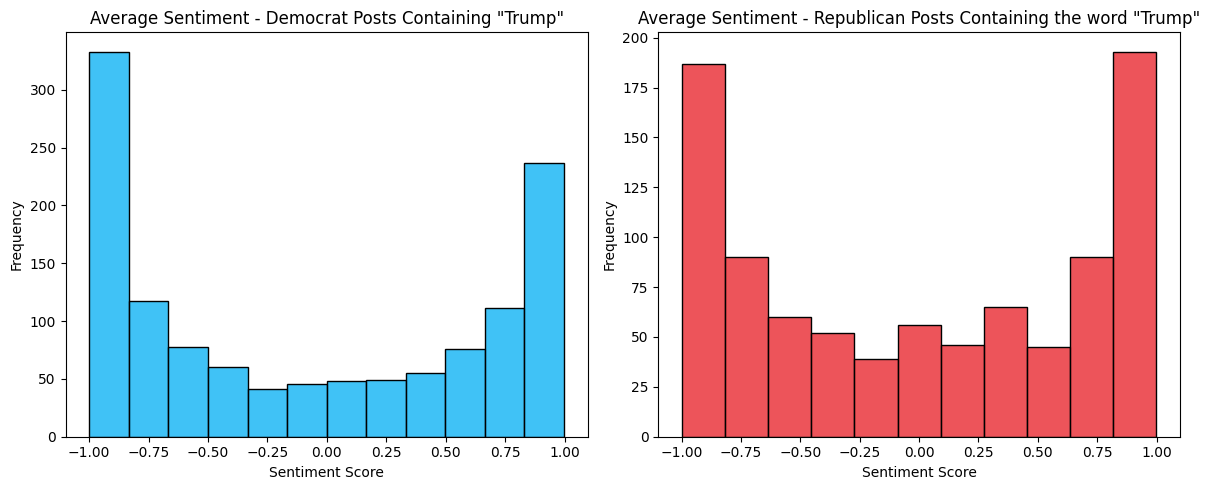

In [62]:
# Plot for Democrat-aligned posts containing 'Trump'
plt.figure(figsize=(12, 5))

# Plot for Average Sentiment of Democrat-Aligned Posts containing 'Trump'
plt.subplot(1, 2, 1)
sns.histplot(df_trump_democrat['vader_sentiment_avg'], color=custom_palette['Democrat'])
plt.title("Average Sentiment - Democrat Posts Containing \"Trump\"")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")

# Plot for Average Sentiment of Republican-Aligned Posts containing 'Trump'
plt.subplot(1, 2, 2)
sns.histplot(df_trump_republican['vader_sentiment_avg'], color=custom_palette['Republican'])
plt.title("Average Sentiment - Republican Posts Containing the word \"Trump\"")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")

plt.tight_layout() 
plt.show()

#### 5.4.2 Posts containing "Sexual Orientation"

In [63]:
df_sx_orientation = df[df['normalized_text'].str.contains('sexual orientation', case=False, na=False)]

In [64]:
# Filter for Democrat-aligned posts containing 'Trans'
df_sx_orientation_democrat = df_sx_orientation[df_sx_orientation['political_alignment_label'] == 'Democrat']

In [65]:
# Filter for Republican-aligned posts containing 'Trans'
df_sx_orientation_republican = df_sx_orientation[df_sx_orientation['political_alignment_label'] == 'Republican']

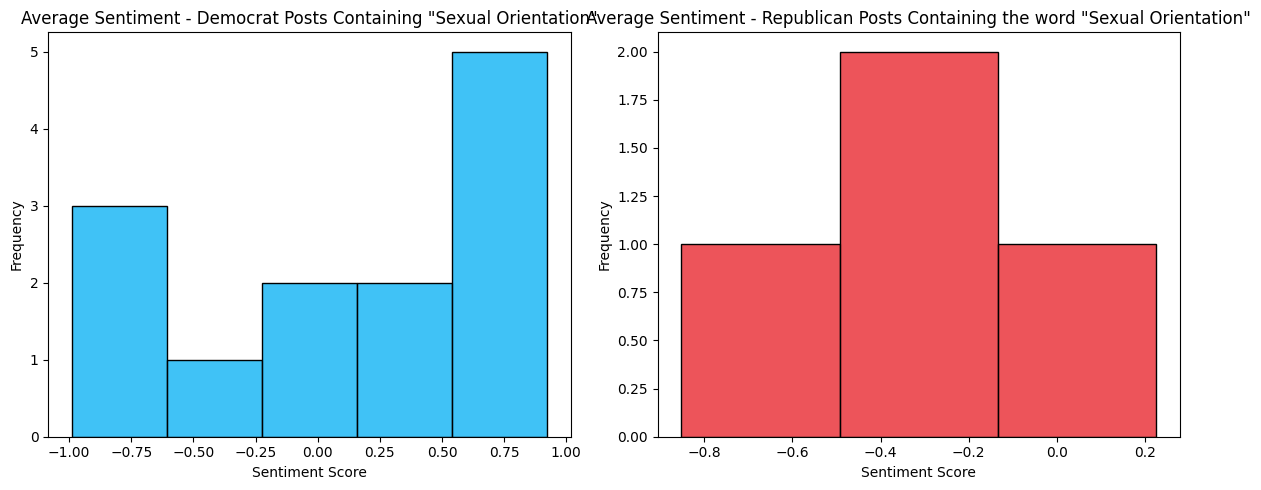

In [66]:
# Plot for Democrat-aligned posts containing 'Trans'
plt.figure(figsize=(12, 5))

# Plot for Average Sentiment of Democrat-Aligned Posts containing 'Trans'
plt.subplot(1, 2, 1)
sns.histplot(df_sx_orientation_democrat['vader_sentiment_avg'], color=custom_palette['Democrat'])
plt.title("Average Sentiment - Democrat Posts Containing \"Sexual Orientation\"")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")

# Plot for Average Sentiment of Republican-Aligned Posts containing 'Trans'
plt.subplot(1, 2, 2)
sns.histplot(df_sx_orientation_republican['vader_sentiment_avg'], color=custom_palette['Republican'])
plt.title("Average Sentiment - Republican Posts Containing the word \"Sexual Orientation\"")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

#### 5.4.3 Post containing "Tax cut"

In [67]:
df_tax_cut = df[df['normalized_text'].str.contains('tax cut', case=False, na=False)]

In [68]:
# Filter for Democrat-aligned posts containing 'Tax Cut'
df_tax_cut_democrat = df_tax_cut[df_tax_cut['political_alignment_label'] == 'Democrat']

In [69]:
# Filter for Republican-aligned posts containing 'Tax Cut'
df_tax_cut_republican = df_tax_cut[df_tax_cut['political_alignment_label'] == 'Republican']

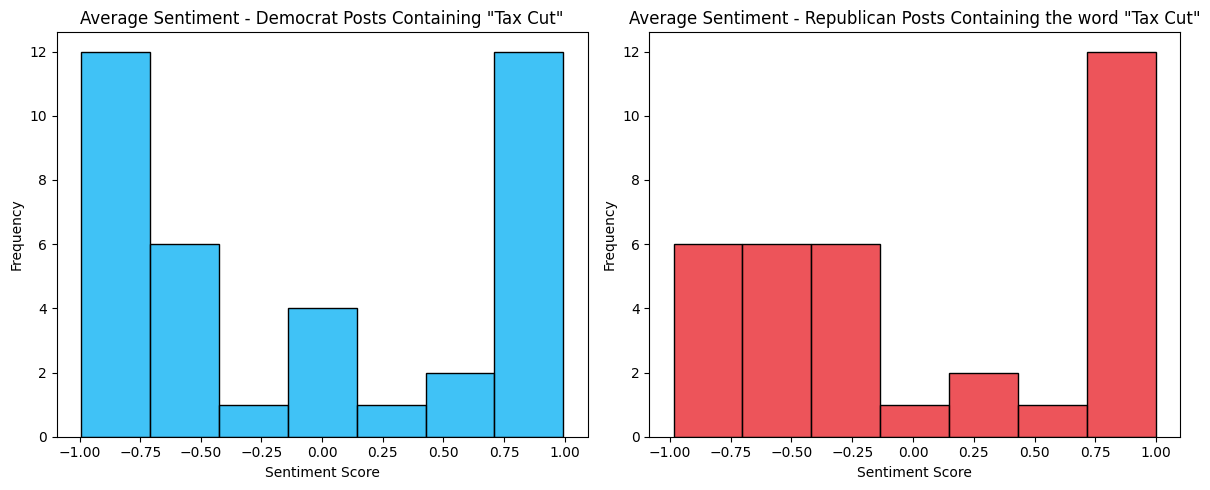

In [70]:
# Plot for Democrat-aligned posts containing 'Tax Cut'
plt.figure(figsize=(12, 5))

# Plot for Average Sentiment of Democrat-Aligned Posts containing 'Tax Cut'
plt.subplot(1, 2, 1)
sns.histplot(df_tax_cut_democrat['vader_sentiment_avg'], color=custom_palette['Democrat'])
plt.title("Average Sentiment - Democrat Posts Containing \"Tax Cut\"")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")

# Plot for Average Sentiment of Republican-Aligned Posts containing 'Trans'
plt.subplot(1, 2, 2)
sns.histplot(df_tax_cut_republican['vader_sentiment_avg'], color=custom_palette['Republican'])
plt.title("Average Sentiment - Republican Posts Containing the word \"Tax Cut\"")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

#### 5.4.4 Posts containing 'Illegal Immigration'

In [71]:
df_ill_imm = df[df['normalized_text'].str.contains('illegal immigration', case=False, na=False)]

In [72]:
# Filter for Democrat-aligned posts containing 'Illegal Immigration'
df_ill_imm_democrat = df_ill_imm[df_ill_imm['political_alignment_label'] == 'Democrat']

In [73]:
# Filter for Republican-aligned posts containing 'Illegal Immigration'
df_ill_imm_republican = df_ill_imm[df_ill_imm['political_alignment_label'] == 'Republican']

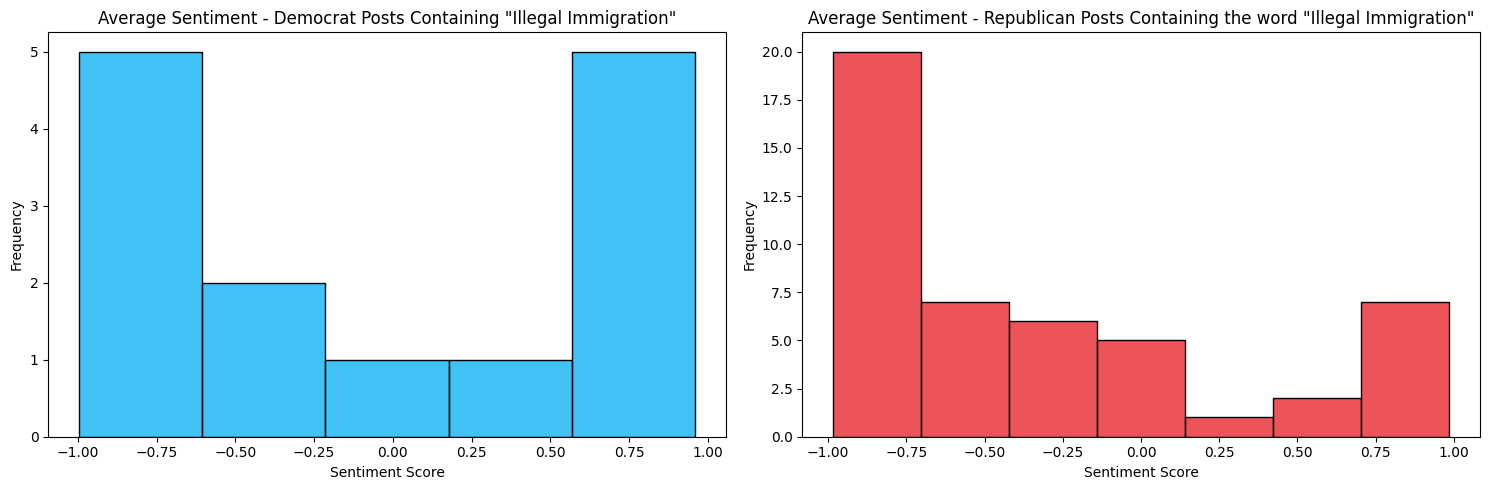

In [74]:
# Plot for Democrat-aligned posts containing 'Tax Cut'
plt.figure(figsize=(15, 5))

# Plot for Average Sentiment of Democrat-Aligned Posts containing 'Illegal Immigration'
plt.subplot(1, 2, 1)
sns.histplot(df_ill_imm_democrat['vader_sentiment_avg'], color=custom_palette['Democrat'])
plt.title("Average Sentiment - Democrat Posts Containing \"Illegal Immigration\"")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")

# Plot for Average Sentiment of Republican-Aligned Posts containing 'Illegal Immigration'
plt.subplot(1, 2, 2)
sns.histplot(df_ill_imm_republican['vader_sentiment_avg'], color=custom_palette['Republican'])
plt.title("Average Sentiment - Republican Posts Containing the word \"Illegal Immigration\"")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

#### 5.4.5 Posts containing 'Federal Government'

In [75]:
df_fed_gov = df[df['normalized_text'].str.contains('federal government', case=False, na=False)]

In [76]:
# Filter for Democrat-aligned posts containing 'Federal Government'
df_fed_gov_democrat = df_fed_gov[df_fed_gov['political_alignment_label'] == 'Democrat']

In [77]:
# Filter for Republican-aligned posts containing 'Federal Government'
df_fed_gov_republican = df_fed_gov[df_fed_gov['political_alignment_label'] == 'Republican']

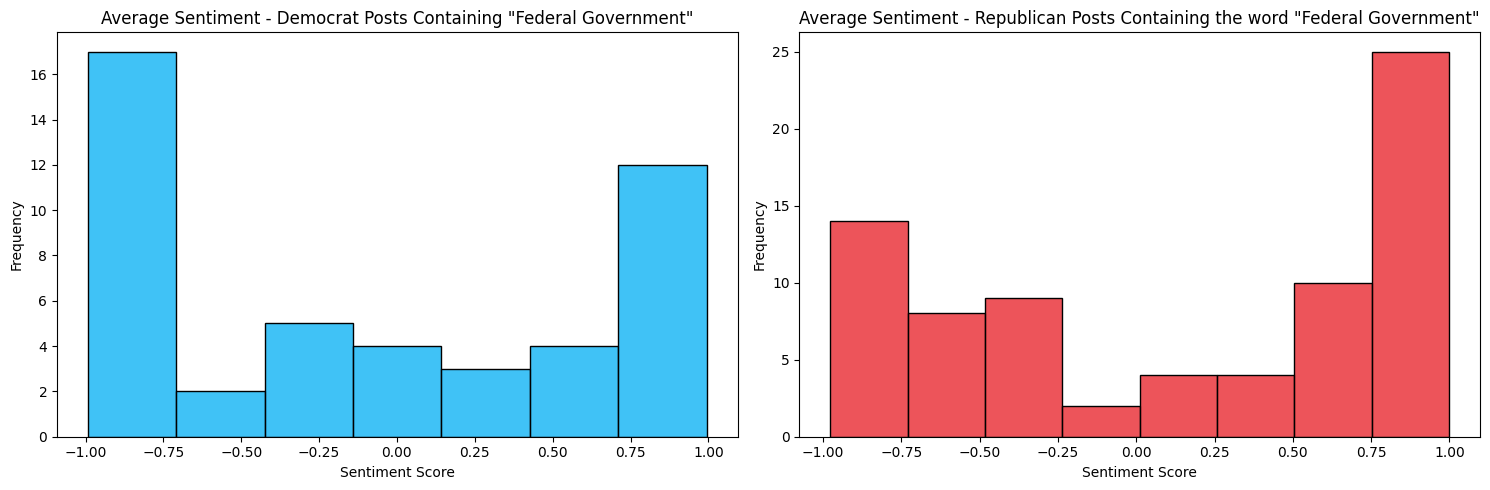

In [78]:
# Plot for Democrat-aligned posts containing 'Federal Government'
plt.figure(figsize=(15, 5))

# Plot for Average Sentiment of Democrat-Aligned Posts containing 'Federal Government'
plt.subplot(1, 2, 1)
sns.histplot(df_fed_gov_democrat['vader_sentiment_avg'], color=custom_palette['Democrat'])
plt.title("Average Sentiment - Democrat Posts Containing \"Federal Government\"")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")

# Plot for Average Sentiment of Republican-Aligned Posts containing 'Federal Government'
plt.subplot(1, 2, 2)
sns.histplot(df_fed_gov_republican['vader_sentiment_avg'], color=custom_palette['Republican'])
plt.title("Average Sentiment - Republican Posts Containing the word \"Federal Government\"")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

#### 5.4.6 Posts containing 'Red Flag Law'

In [79]:
df_red_flag = df[df['normalized_text'].str.contains('red flag law', case=False, na=False)]

In [80]:
# Filter for Democrat-aligned posts containing 'Red Flag Law'
df_red_flag_democrat = df_red_flag[df_red_flag['political_alignment_label'] == 'Democrat']

In [81]:
# Filter for Republican-aligned posts containing 'Red Flag Law'
df_red_flag_republican = df_fed_gov[df_fed_gov['political_alignment_label'] == 'Republican']

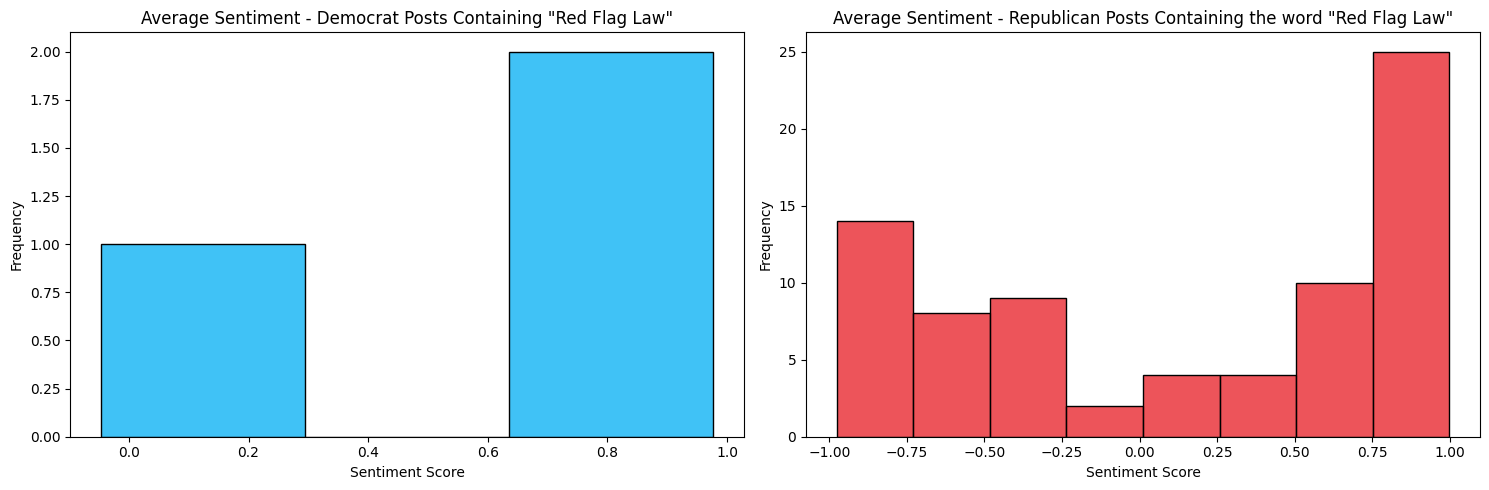

In [82]:
# Plot for Democrat-aligned posts containing 'Red Flag Law'
plt.figure(figsize=(15, 5))

# Plot for Average Sentiment of Democrat-Aligned Posts containing 'Red Flag Law'
plt.subplot(1, 2, 1)
sns.histplot(df_red_flag_democrat['vader_sentiment_avg'], color=custom_palette['Democrat'])
plt.title("Average Sentiment - Democrat Posts Containing \"Red Flag Law\"")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")

# Plot for Average Sentiment of Republican-Aligned Posts containing 'Red Flag Law'
plt.subplot(1, 2, 2)
sns.histplot(df_red_flag_republican['vader_sentiment_avg'], color=custom_palette['Republican'])
plt.title("Average Sentiment - Republican Posts Containing the word \"Red Flag Law\"")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## 6. Insights and Findings

1. Comment distribution:
   - The dataset contains a balanced number of Democrat-aligned and Republican-aligned entries, ensuring fair representation for both political groups.
2. Text Analysis:
   - A significant number of comments are longer than 400 characters, suggesting that longer posts often contain more elaborate and opinionated content.
   - The analysis of frequent unigrams, bigrams, and trigrams by political alignment reveals distinct language patterns, which may serve as valuable features for predictive modeling.
3. Sentiment Analysis:
   - Posts containing politically charged keywords (e.g., “Trump”, “tax cut”, “sexual orientation”) exhibit notable differences in sentiment scores between political alignments.
   - These variations suggest that I should try using opinionated posts rather than neutral ones.

In [109]:
df_opinionated = df[
    (df['vader_sentiment_avg'].abs() >= 0.0) & 
    (df['text'].str.len() > 400)
]

In [110]:
df_opinionated['political_alignment'].value_counts()

political_alignment
0    3575
1    2586
Name: count, dtype: int64

In [111]:
df_opinionated.to_csv('./data/political_opinionated.csv', index=False)